Over the past decade, **memes** has became very popular in
many areas such as computer science, marketing, health
care, sociology, technology etc and day by day as people are
spending more time over internet, it’s popularity is
increasing, it’s all because it passes informations with a
pinch of humor. During this some of the memes becomes
viral and there should be a reason for becoming a meme
viral.<br><br>
**In this project I will try to find the reason behind becoming
a meme viral and try to predict whether a meme will become viral or not based on data provided for meme and information available in the meme**. <br><br>For this project I will collect data from many subreddits of **Reddit**, from largest meme subreddit to lowest one in terms of subscribers, so that we get memes of every flavours. For this project I will use memes in the form of images (no gif and no video) and data available for the post of the meme such as time of post, number of
upvotes, size of image etc. After data collection I will frame the problem as binary classification by denoting popular memes based on upvotes and number of subscribers of subreddit as 1 and non-popular meme as 0. Now, this is a binary classification problem.

In [23]:
#importing libraries
import pandas as pd
import numpy as np
import datetime as dt
import requests
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5sAB80AF2-H_H2dtNhAozFGnQxT7Ljx9Pi9m7MEgRuQiX1_d8qcXo
Mounted at /content/drive


# **Data Collection**

I am going to collect data for this from **Reddit**. Reddit has many subreddits for memes and also Reddit provides an API called **Pushshift API** to easily get data from Reddit. So, I am goind to use that API to collect data from Reddit.

In [ ]:
#installing psaw (Pushshift.io API Wrapper)
!pip install psaw

In [ ]:
#importing pushshift API
from psaw import PushshiftAPI

In [ ]:
api = PushshiftAPI()

I am collecting data on 31st May 2021. I am not going to collect very latest or very old data, I am going to collect 6 month old data so that memes gets enough time to be viral and it should also show the latest trend of memes.
<br><br>

In [ ]:
#dates between which memes are being collected
start_date=int(dt.datetime(2020, 11, 1).timestamp())
end_date=int(dt.datetime(2020, 11, 20).timestamp())

In [ ]:
#list of subreddits from whom I am going to collect data
lst_subreddits = ['meme','memes','4PanelCringe','teenagers','dankmemes','PrequelMemes','HistoryMemes',
                  'MemePiece','funny','MadeOfStyrofoam']

In [ ]:
#Creating an empty dataframe whith required columns to concatenate data from each subreddits of the list
dataset = pd.DataFrame(columns=['author','created_utc','is_original_content','is_video','num_comments',
                                'over_18','subreddit','subreddit_subscribers','thumbnail','title','upvote_ratio', 
                                'url','thumbnail_height', 'thumbnail_width','score'])

In [ ]:
#iterating over each subreddits and collecting necessary data
for i in lst_subreddits:
  api_request_generator = api.search_submissions(subreddit = i,
                                                 after = start_date,
                                                 before = end_date,
                                                 filter=['author','created_utc','is_original_content','is_video','num_comments','over_18',
                                                         'subreddit','subreddit_subscribers','thumbnail','title','upvote_ratio', 'url',
                                                         'thumbnail_height', 'thumbnail_width','score'],
                                                 limit=30000)
  aita_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])
  dataset = pd.concat([dataset, aita_submissions], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/usr/local/lib/python3.7/dist-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [ ]:
dataset.shape

(166993, 16)

I have collected 166993 data with 16 columns

In [ ]:
#numbers of data from each subreddits
dataset.subreddit.value_counts()

funny              30000
memes              30000
teenagers          30000
dankmemes          30000
meme               25336
PrequelMemes       10380
HistoryMemes        8405
MadeOfStyrofoam     1674
MemePiece            882
4PanelCringe         316
Name: subreddit, dtype: int64

In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
dataset.to_csv('dataset.csv', index=False)

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Applied_ai/dataset.csv")

In [ ]:
#here I will deal with only images, so removing data which are not images
df = dataset[dataset['url'].str.endswith(('jpg','png','jpeg'))]

In [ ]:
df.shape[0]

123557

Now we are left with 123557 image data, now we will remove all those data whose links are not working of giving error.

In [ ]:
'''
removing all those data whose links are not starting with 'https' because,
I am also going to extract data from images so, if the link to image will not work then
I can't extract data from image for that post
'''
df = df[df['url'].str.startswith(('https'))]

**Some of the data collections are very time consuming, so for that I am going to use multiprocessing**

In [ ]:
#importing multiprocessing library
import multiprocessing
from multiprocessing import  Pool

In [ ]:
#Getting status code of each URLs. If status code is 200 then url is working otherwise not
def status_code(urls):
  stat_code = []
  for i in tqdm(urls, position=0):
    try: 
      stat_code.append(requests.get(i).status_code)
    except:
      stat_code.append('error')
  return pd.DataFrame(stat_code)

In [ ]:
#Reference : https://towardsdatascience.com/make-your-own-super-pandas-using-multiproc-1c04f41944a1
def parallelize_dataframe(urls, func, n_cores=4):
    df_split = np.array_split(urls, n_cores)
    pool = Pool(n_cores)
    stat_code = pd.concat(pool.map(func, df_split), ignore_index=True)
    pool.close()
    pool.join()
    return stat_code

In [ ]:
stat_code = parallelize_dataframe(df['url'], status_code)

 53%|█████▎    | 16519/30887 [40:43<51:36,  4.64it/s]

In [ ]:
df['status_code'] = 0

In [ ]:
#making status code as new column of the dataset
df['status_code'] = stat_code[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#removing all data whose status code is not 200
df = df[df['status_code']==200]

In [ ]:
df.shape

(84359, 17)

Now we are left with only **84359** data

In [ ]:
#dropping unnecessary columns
df.drop(['created','status_code','thumbnail','author'], axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now we are left with **84359** rows and **13** columns.

In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
df.to_csv('df_wrk_lnk.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Applied_ai/df_wrk_lnk.csv')


### <br><br>Getting sentiment score for title column
<br>

To compute sentiment score I have used pre-trained model by:<br>
https://medium.com/analytics-vidhya/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5

This is a LSTM based model trained on **[Stanford sentiment treebank data](https://nlp.stanford.edu/sentiment/code.html)** (dictionary.txt) which has 239233 rows. The index is used to match each of the sentences to a sentiment score in the file “labels.txt”. The score ranges from 0 to 1, 0 being very negative and 1 being very positive.<br><br>
I am computing sentiment score before extracting text from the image using OCR and combining with title column and cleaning, because I am going to use stemming so the original word will be lost and also the text extracted from the image will have many errors. So, I decided to compute sentiment score on title only and also title is the reflection of content in the meme template. 

In [ ]:
from tensorflow import keras
import json
from nltk.tokenize import RegexpTokenizer

#loading pre trained model and word index
pred_model = keras.models.load_model('/content/drive/MyDrive/Applied_ai/best_model.hdf5')
word_idx = json.load(open("/content/drive/MyDrive/Applied_ai/word_idx.txt"))

In [ ]:
#function to compute sentiment score
def get_sentiment_DL(prd_model, text_data, word_idx):

    live_list = []
    batchSize = len(text_data)
    live_list_np = np.zeros((56,batchSize))

    mask = [isinstance(item, (str, bytes)) for item in text_data['title']]
    text_data = text_data.loc[mask]

    for index, row in text_data.iterrows():
        

        text_data_sample = text_data['title'][index]
        
        # split the sentence into its words and remove any punctuations.
        tokenizer = RegexpTokenizer(r'\w+')
        text_data_list = tokenizer.tokenize(text_data_sample)
        if len(text_data_list)>56:
          text_data_list = text_data_list[:56]

        labels = np.array(['1','2','3','4','5','6','7','8','9','10'], dtype = "int")
        
        # get index for the live stage
        data_index = np.array([word_idx[word.lower()] if word.lower() in word_idx else 0 for word in text_data_list])
        data_index_np = np.array(data_index)

        # padded with zeros of length 56 i.e maximum length
        padded_array = np.zeros(56)
        padded_array[:data_index_np.shape[0]] = data_index_np
        data_index_np_pad = padded_array.astype(int)


        live_list.append(data_index_np_pad)

    live_list_np = np.asarray(live_list)
    score = prd_model.predict(live_list_np, batch_size=64, verbose=0)
    single_score = np.round(np.dot(score, labels)/10,decimals=2)
    score_all  = []
    for each_score in score:

        top_3_index = np.argsort(each_score)[-3:]
        top_3_scores = each_score[top_3_index]
        top_3_weights = top_3_scores/np.sum(top_3_scores)
        single_score_dot = np.round(np.dot(top_3_index, top_3_weights)/10, decimals = 2)
        score_all.append(single_score_dot)

    text_data['Sentiment_Score'] = pd.DataFrame(score_all)

    return text_data

In [ ]:
df = get_sentiment_DL(pred_model, df, word_idx)

### <br><br>Extracting texts from images using OCR
Memes will have texts written in images, here I am going to extract those texts.
<br>

In [ ]:
#installing pytesseract
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13953 sha256=a44523d97b611b638d03019bbae5e5a27716b6ae1153f5d3e2d4c14d0189d1ce
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (28.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [ ]:
#importing libraries
import cv2 
import pytesseract
from skimage import io
from google.colab.patches import cv2_imshow

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
#creating a column to store extracted text
df['img_txt']=0

In [ ]:
"""
This function will extract text from image. It takes url of image as input and
extracts text from image using pytesseract.
"""
def extract_text(url):
  try:
    im = io.imread(url)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, im = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY) 
    custom_config = r"--oem 3 --psm 11 -c tessedit_char_whitelist= 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '"
    text = pytesseract.image_to_string(im, lang='eng', config=custom_config)
    return text.replace('\n', ' ')
  except:
    return " "

In [ ]:
tqdm.pandas(position=0)
df['img_txt'] = df['url'].progress_apply(extract_text)

In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
df.to_csv("df_img_txt.csv")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Applied_ai/df_img_txt.csv')

<br>

In [ ]:
#combining all text columns to one column and dropping the columns which are being combined
df['text'] = df['title']+df['img_txt']
df.drop(['title','img_txt'], axis=1, inplace=True)

### <br><br>Cleaning text column
<br>

In [ ]:
#importing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

In [ ]:
#downloading punkt and stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#this function will take text as input and will clean it and return cleaned text
def clean_text(text):
    text = re.sub('[^A-Za-z]',' ',text).lower()    #Removing all characters from text except alphabets
    words = word_tokenize(text)
    stopWords = set(stopwords.words('english'))
    ps = PorterStemmer()
    cleanedText = []
    for word in words:
        word = ps.stem(word)
        if word in stopWords or len(word)<=4:      #Removing stopwords and words with length less than 5
            continue
        else:
            cleanedText.append(word)
    return " ".join(set(cleanedText))

In [ ]:
tqdm.pandas(position=0)
#calling function to clean the text
df['text'] = df['text'].progress_apply(clean_text)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 84359/84359 [01:23<00:00, 1015.38it/s]


In [ ]:
#new feature containing number of words in text
df['num_words'] = df['text'].str.split().apply(len)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Applied_ai/df_img_feature_pred.csv')

### <br><br>Extracting HSV value from the image
Extracting Hue, Saturation and Value of the image.
<br>

In [ ]:
#Reference : https://www.codespeedy.com/splitting-rgb-and-hsv-values-in-an-image-using-opencv-python/
#This function will take url as input and return average Hue, Saturation and Value of the image 
def get_avg_hsv(url):
  try:
    im = io.imread(url)
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    return [h.mean(), s.mean(), v.mean()]
  except:
    return [0,0,0]

In [ ]:
#this function will apply the above function to url column of the dataset
def hsv(df):
  tqdm.pandas(position=0)
  avg_hsv = df.progress_apply(get_avg_hsv)
  return avg_hsv

In [ ]:
#This function will help to parallelize our process
def parallelize_dataframe(urls, func, n_cores=4):
    df_split = np.array_split(urls, n_cores)
    pool = Pool(n_cores)
    avg_hsv = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return avg_hsv

In [ ]:
avg_hsv = parallelize_dataframe(df['url'], hsv)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/21090 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/21090 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  4%|▍         | 888/21090 [02:27<

In [ ]:
#creating columns to store average Hue, Saturation and Value of the image
df['avg_h'] = np.matrix(avg_hsv.tolist())[:,0]
df['avg_s'] = np.matrix(avg_hsv.tolist())[:,1]
df['avg_v'] = np.matrix(avg_hsv.tolist())[:,2]

In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
df.to_csv("df_hsv.csv")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Applied_ai/df_hsv.csv')

### <br><br>Extracting colors from images
Extracting normalized number of pixels with certain color in the image.
<br>

In [ ]:
#Reference : https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/
#Reference : https://realpython.com/python-opencv-color-spaces/
#Reference : https://alloyui.com/examples/color-picker/hsv.html
'''
gimp uses HSV value in range of H = 0-360, S = 0-100 and V = 0-100. 
But OpenCV uses H: 0-179, S: 0-255, V: 0-255.
So, when we will try to get a HSV value it will be in gimp's form. We have to convert
that so that it can be used by Opencv.
H(opencv) = H(gimp)/2
S(opencv) = (S(gimp)*255)/100
V(opencv) = (V(gimp)*255)/100 
'''
boundries = [([0,0,200],[180,25,255]),      #white
              ([0,0,0],[180,255,3]),        #black
              ([0,0,100],[180,20,180]),        #gray
              ([0,90,115],[17,255,190]),     #brown
              ([20,50,240],[30,75,255]),     #off-white
              ([0,140,155],[12,255,230]),      #dark red
              ([0,140,230],[12,255,255]),     #light red
              ([13,190,155],[17,255,230]),     #dark orange
              ([13,140,230],[115,255,255]),    #light orange
              ([18,140,155],[140,255,230]),     #goldish
              ([23,140,230],[165,255,255]),    #yellow
              ([28,90,155],[80,255,230]),    #dark green
              ([33,90,230],[77,255,255]),   #light green
              ([85,77,153],[93,255,230]),   #dark cyan
              ([85,77,230],[93,255,255]),  #cyan
              ([100,128,90],[125,255,190]),   #dark blue
              ([100,128,193],[125,255,255]),  #light blue
              ([142,102,153],[150,255,255]),  #purple
              ([158,102,180],[160,255,255]),  #pink
              ([0,0,255],[180,25,255])      #faded colors
]

In [ ]:
#function to extract color from image
def extract_color(url):
  try:
    im = io.imread(url)
    num_pixel = im.shape[0] * im.shape[1]
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    clr_pixel = []

    for(lower, upper) in boundries:
      lower = np.array(lower, dtype = "uint8")
      upper = np.array(upper, dtype = "uint8")
      mask = cv2.inRange(hsv, lower, upper)
      clr_pixel.append(round(((mask==255).sum())/num_pixel,5)) #counting and normalizing number of pixels

    return clr_pixel

  except:
    return [0]*20

In [ ]:
#this function will apply the above function to url column of the dataset
def color(df):
  tqdm.pandas(position=0)
  norm_pix = df.progress_apply(extract_color)
  return norm_pix

In [ ]:
#This function will help to parallelize our process
def parallelize_data_color(urls, func, n_cores=4):
    df_split = np.array_split(urls, n_cores)
    pool = Pool(n_cores)
    norm_pix = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return norm_pix

In [ ]:
norm_pix_img = parallelize_data_color(df['url'], color)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/21090 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/21090 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  4%|▍         | 863/21090 [04:44<

In [ ]:
colors = ['white','black','gray','brown','off-white','dark red','light red','dark orange','light orange',
          'goldish','yellow','dark green','light green','dark cyan','cyan','dark blue','light blue',
          'purple','pink','faded colors'
        ]

In [ ]:
#adding new color features to the dataset
for i, color in enumerate(colors):
  df[color] = np.matrix(norm_pix_img.tolist())[:,i]

In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
df.to_csv('df_color.csv')

### <br><br>Extracting features from images
Each meme is in the form of image so, there will be image of objects in the image. Here I am going to extract those objects with their respective probabilities.
<br>

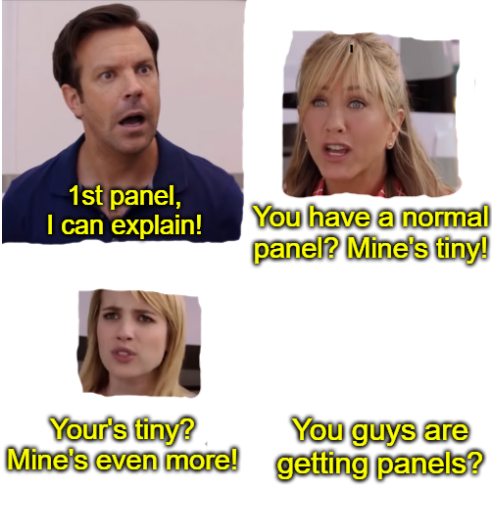

Image above is a meme image, here we can see that there are human faces so we have to extract those objects. We can also see that there are texts in the images which can be extracted using OCR.

In [36]:
df = pd.read_csv('/content/drive/MyDrive/Applied_ai/df_color.csv')

In [ ]:
#importing libraries
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
# load the model
model = VGG16()

553476096/553467096 [==============================] - 8s 0us/step


In [ ]:
#this function will take url of image as input and will get the image and convert it to array and return it
def load_image(link, target_size=None):
    import requests
    import shutil
    import os
    
    _, ext = os.path.splitext(link)
    
    r = requests.get(link, stream=True)
    with open('temp.' + ext, 'wb') as f:
        r.raw.decode_content = True
        shutil.copyfileobj(r.raw, f)
        
    img = image.load_img('temp.' + ext, target_size=target_size)
    return image.img_to_array(img)

In [ ]:
#this function will extract features and their probabilities from image and return them
def extract_feature_from_image(url):
  try:
    im = load_image(url, target_size=(224, 224))
    im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
    im = preprocess_input(im)
    yhat = model.predict(im)
    label = decode_predictions(yhat, top=3)
    obj = []
    pred = []
    for i in label[0]:
      obj.append(i[1])
      pred.append(i[2])
    return [obj,pred]
  
  except:
    return [[""]*3, [0]*3]

In [ ]:
tqdm.pandas(position=0)
img_feature_pred = df['url'].progress_apply(extract_feature_from_image)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/20000 [00:00<?, ?it/s]

49152/35363 [=========================================] - 0s 0us/step


100%|██████████| 20000/20000 [1:11:26<00:00,  4.67it/s]


In [ ]:
#creating new columns in the dataset to store new features
df['img_feature'] = np.empty(84359, dtype=object)
df['img_feature_pred'] = np.empty(84359, dtype=object)

In [ ]:
#adding newly generated features to the dataset
df['img_feature'] = [i[0] for i in img_feature_pred]
df['img_feature_pred'] = [i[1] for i in img_feature_pred]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
df.to_csv('df_img_feature_pred.csv',index=False)

### <br><br>Dropping Duplicates<br>
In this dataset we have many such rows in which urls are repeated means duplicate urls. Here I am going to drop such data.
<br>

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Applied_ai/df_senti.csv")

In [ ]:
#dropping rows based on duplicate urls, because urls are unique for each posts
df.drop_duplicates(subset=['url'], inplace=True)

In [ ]:
df.shape[0]

83908

After dropping duplicate values we are left with **83908** data points.

In [ ]:
df.to_csv('df_dup.csv')

### <br><br>Dank or Not
Marking data points whether they are dank or not based on normalized score.
<br>

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Applied_ai/df_dup.csv")

In [ ]:
'''
Subreddits with more subscribers tend to get more upvotes, so I am normalizing the number of score by dividing by
the number of subscribers from the respective subreddit where it was posted.
'''
df['score'] = df['score']/df['subreddit_subscribers']

In [ ]:
'''
Checking percentile value of normalized score, so that I can get clear understanding for denoting meme 
as dank or not and making the problem as binary classification problem. 
'''
#checking for top 5 precentile value
top_5_percentile_value = []
for i in range(95,101):
  top_5_percentile_value.append(np.percentile(df['score'], i))
print(top_5_percentile_value)

[3.325298850927006e-05, 5.056514246890454e-05, 9.213297312491056e-05, 0.00027083459833780814, 0.0011930512218034238, 0.04379447631587197]


Here we can see that there is huge difference between 97th percentile and 98th percentile values. Now lets see between 97th and 98th percentile value.

In [ ]:
between_97_98_percentile_value = []
for i in np.arange(0,1,0.1):
  between_97_98_percentile_value.append(np.percentile(df['score'], (97+i)))
print(between_97_98_percentile_value)

[9.213297312491056e-05, 9.876765417343272e-05, 0.00010782892342374918, 0.00011894073047119614, 0.00013161383827601996, 0.00014826367003786453, 0.00016494926074253738, 0.00019130394673566036, 0.00021475232856997734, 0.0002408797951039637]


Here we can see that, there is huge difference between 97.1 percentile value and 97.2 percentile value.<br>
So, I will mark data with normalized score value greater than 97.1 percentile as 1 and others as 0.

In [ ]:
df['dank_or_not'] = (df['score']>np.percentile(norm_score, 97.1)).astype('int')

In [ ]:
df['dank_or_not'].value_counts()

0    81474
1     2434
Name: dank_or_not, dtype: int64

Here we have only **2434** dank data points i.e. only **2.9%** of the dataset.

In [ ]:
df.to_csv('df_dankornot.csv', index=False)

### <br><br>**Data cleaning and feature encoding**<br>
cleaning the dataset and encoding the categorical features of the dataset.
<br>


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Applied_ai/df_dankornot.csv")

### Encoding created_utc column and creating new 'hour' column

The created_utc feature contains the timestamp when the post appeared on Reddit in the Coordinated Universal Time zone (UTC). Since most active Reddit users reside inthe USA, we converted this to North American Central Time Zone.

In [ ]:
from datetime import datetime
from pytz import timezone
import pytz

In [ ]:
fmt = "%Y-%m-%d %H:%M:%S %Z%z"

In [ ]:
datetime_converted = df['created_utc'].apply(datetime.fromtimestamp)

In [ ]:
datetime_converted=pd.DatetimeIndex(datetime_converted).tz_localize('UTC').tz_convert('America/New_York')

In [ ]:
df['created_utc'] = pd.to_datetime(datetime_converted)

In [ ]:
#creating hour column
df['hour'] = df['created_utc'].apply(lambda x: x.hour)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83908 entries, 0 to 83907
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype                           
---  ------                 --------------  -----                           
 0   created_utc            83908 non-null  datetime64[ns, America/New_York]
 1   is_original_content    83908 non-null  bool                            
 2   is_video               83908 non-null  bool                            
 3   num_comments           83908 non-null  int64                           
 4   over_18                83908 non-null  bool                            
 5   subreddit              83908 non-null  object                          
 6   subreddit_subscribers  83908 non-null  int64                           
 7   upvote_ratio           83908 non-null  float64                         
 8   url                    83908 non-null  object                          
 9   thumbnail_height       83842 non-null  

Since we have only images so lets see 'is_video' column.

In [ ]:
df['is_video'].value_counts()

False    83908
Name: is_video, dtype: int64

'is_video' column have only one value i.e. False so, dropping this column.

In [ ]:
df.drop(['is_video'], axis=1, inplace=True)

thumbnail_height, thumbnail_width and text columns have some null values. <br><br>
For text column there can be possibility that memes have only image no titles and no texts on images so in this case there will be no text for some data points. We can fill that NaN value with empty string.

In [ ]:
df['text'] = df['text'].fillna("")

Now checking thumbnail_height and thumbnail_width columns.

In [ ]:
df[df['thumbnail_height'].isna()]

,created_utc,is_original_content,num_comments,over_18,subreddit,subreddit_subscribers,upvote_ratio,url,thumbnail_height,thumbnail_width,text,num_words,avg_h,avg_s,avg_v,img_feature,img_feature_pred,sentiment_score,score,dank_or_not,white,black,gray,brown,off-white,dark red,light red,dark orange,light orange,goldish,yellow,dark green,light green,dark cyan,cyan,dark blue,light blue,purple,pink,faded colors,hour
5393,2020-11-14 23:27:53-05:00,False,1,False,meme,1298061,1.0,https://i.imgur.com/oma878F.jpg,NaN,NaN,ballot,1,53.036308,28.291020,171.855544,"['bulletproof_vest', 'abaya', 'web_site']","[0.10988305, 0.103418946, 0.061924294]",0.55,7.703798e-07,0,0.41796,0.00228,0.06713,0.00162,0.00000,0.00000,0.00000,0.00000,0.00000,0.00012,0.00000,0.00000,0.0,0.00001,0.00000,0.00075,0.00008,0.00000,0.0,0.18839,23
5636,2020-11-14 16:23:22-05:00,False,0,False,meme,1297737,1.0,https://i.redd.it/prchjpdnv9z51.png,NaN,NaN,possibl format,2,73.072046,86.844145,95.885070,"['washbasin', 'bathtub', 'comic_book']","[0.23497044, 0.08969612, 0.06683026]",0.39,7.705722e-07,0,0.21137,0.11831,0.02412,0.00075,0.00054,0.00007,0.00000,0.00002,0.00005,0.00084,0.00000,0.00000,0.0,0.00000,0.00000,0.00179,0.00034,0.00000,0.0,0.19569,16
5637,2020-11-14 16:23:21-05:00,False,0,False,meme,1297737,1.0,https://i.redd.it/ecz3jfp1w9z51.jpg,NaN,NaN,controllerpi,1,74.676223,67.688197,150.885452,"['chain_saw', 'mousetrap', 'iron']","[0.38112277, 0.2484691, 0.07410673]",0.50,7.705722e-07,0,0.15248,0.00400,0.14467,0.00001,0.00002,0.00000,0.00000,0.00000,0.00001,0.04771,0.00001,0.01133,0.0,0.00010,0.00000,0.03367,0.02204,0.00000,0.0,0.00198,16
5900,2020-11-14 10:50:22-05:00,False,48,False,meme,1297406,1.0,https://i.redd.it/sh8vta9q88z51.jpg,NaN,NaN,dream focini criht naita becom pirat needm motiv,8,53.515261,63.548291,131.644090,"['comic_book', 'web_site', 'jigsaw_puzzle']","[0.81331664, 0.137077, 0.012578551]",0.58,7.707687e-07,0,0.14216,0.26728,0.01556,0.02549,0.00568,0.01663,0.00041,0.00038,0.01272,0.02249,0.01363,0.00546,0.0,0.00070,0.00032,0.03977,0.02640,0.00000,0.0,0.04458,10
6171,2020-11-14 03:22:19-05:00,False,1,False,meme,1297117,1.0,https://i.redd.it/cal8q0dv06z51.png,NaN,NaN,memento,1,102.112650,40.940901,131.698781,"['cleaver', 'refrigerator', 'butcher_shop']","[0.16202174, 0.066590935, 0.036817644]",0.50,7.709405e-07,0,0.13492,0.00589,0.04636,0.00009,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00005,0.00000,0.00000,0.0,0.00282,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81524,2020-11-04 07:36:48-05:00,False,0,False,funny,33992413,1.0,https://imgur.com/qmO4a65.jpg,NaN,NaN,perfect elect,2,76.888766,36.488028,127.915276,"['lab_coat', 'barbershop', 'book_jacket']","[0.14896993, 0.10607306, 0.06514196]",0.72,2.941833e-08,0,0.02457,0.00154,0.19386,0.00004,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00006,0.0,0.00001,0.00000,0.00013,0.00000,0.00000,0.0,0.00411,7
81701,2020-11-03 22:57:57-05:00,False,1,False,funny,33986942,1.0,https://i.imgur.com/yXKXDM8.jpg,NaN,NaN,light suspicio,2,75.514534,65.760486,206.202395,"['comic_book', 'web_site', 'envelope']","[0.51752347, 0.39471337, 0.019858938]",0.51,2.942306e-08,0,0.29232,0.00273,0.01394,0.01940,0.00000,0.01252,0.00000,0.00000,0.04790,0.00186,0.04792,0.00000,0.0,0.00032,0.00053,0.00396,0.02814,0.00161,0.0,0.04531,22
82041,2020-11-03 14:27:17-05:00,False,1,False,funny,33979867,1.0,https://i.imgur.com/0xsumgC.jpg,NaN,NaN,famili ungrat mamal everyth ingratitudewhen at...,8,88.036268,60.809055,208.397705,"['book_jacket', 'envelope', 'web_site']","[0.19174352, 0.16645181, 0.16387904]",0.39,2.942919e-08,0,0.16872,0.00657,0.00312,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00005,0.00000,0.00000,0.0,0.00000,0.00000,0.02247,0.00002,0.00000,0.0,0.14769,14
82597,2020-11-02 18:17:40-05:00,False,0,False,funny,33963791,1.0,https://i.redd.it/e7cwb6q

Here we can see that the data points which have thumbnail_height as NaN value also have thumbnail_width value as NaN and all other data are present for these data points. So, we can't drop these data points. 

In [ ]:
print(df['thumbnail_height'].value_counts())
print()
print(df['thumbnail_width'].value_counts())

140.0    46553
105.0     2214
78.0      2208
138.0     1126
139.0     1064
         ...  
9.0          1
6.0          1
11.0         1
7.0          1
1.0          1
Name: thumbnail_height, Length: 136, dtype: int64

140.0    83776
70.0        54
56.0         3
42.0         2
68.0         1
62.0         1
1.0          1
9.0          1
66.0         1
4.0          1
8.0          1
Name: thumbnail_width, dtype: int64


Since we have only 66 values missing in these two columns we can fill them with most frequent values because more than half data have 140 thumbnail_height and almost 99% of the data have 140 thumbnail_width.

In [ ]:
df['thumbnail_height'].fillna(df['thumbnail_height'].mode().iloc[0], inplace=True)
df['thumbnail_width'].fillna(df['thumbnail_width'].mode().iloc[0], inplace=True)

In [ ]:
df.describe()

,num_comments,subreddit_subscribers,upvote_ratio,thumbnail_height,thumbnail_width,num_words,avg_h,avg_s,avg_v,sentiment_score,score,dank_or_not,white,black,gray,brown,off-white,dark red,light red,dark orange,light orange,goldish,yellow,dark green,light green,dark cyan,cyan,dark blue,light blue,purple,pink,faded colors,hour
count,83908.000000,8.390800e+04,83908.000000,83908.000000,83908.00000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,8.390800e+04,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000
mean,15.108154,8.977504e+06,0.956594,124.999404,139.94053,5.740144,60.317165,65.436955,146.328532,0.455087,5.955454e-05,0.029008,0.265446,0.051833,0.038259,0.012361,0.000563,0.003367,0.000941,0.001135,0.011016,0.034387,0.012462,0.004405,0.000663,0.003487,0.002683,0.043433,0.018724,0.000367,0.000087,0.157930,12.016113
std,78.849474,1.078705e+07,0.081024,22.762394,2.16647,9.100048,30.748067,39.450338,51.210660,0.110622,7.369022e-04,0.167830,0.241795,0.125486,0.067907,0.043329,0.007306,0.019802,0.010711,0.010926,0.041280,0.068359,0.044014,0.024150,0.009917,0.017635,0.017938,0.073243,0.049329,0.006916,0.001772,0.199843,6.183415
min,0.000000,3.025400e+04,0.080000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.591950e+06,0.940000,112.000000,140.00000,3.000000,37.463102,36.604967,112.196312,0.410000,2.392153e-07,0.000000,0.055627,0.001200,0.006560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000370,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.007300,8.000000
50%,3.000000,4.182826e+06,1.000000,140.000000,140.00000,4.000000,61.089985,61.634183,147.744425,0.480000,7.763978e-07,0.000000,0.206720,0.008890,0.015610,0.000170,0.000000,0.000000,0.000000,0.000000,0.000120,0.006505,0.000190,0.000000,0.000000,0.000010,0.000000,0.012770,0.001060,0.000000,0.000000,0.057520,12.000000
75%,8.000000,1.363697e+07,1.000000,140.000000,140.00000,7.000000,83.546090,89.112960,183.449886,0.500000,4.363476e-06,0.000000,0.404060,0.030000,0.037960,0.004190,0.000020,0.000050,0.000000,0.000000,0.004080,0.035200,0.005340,0.000160,0.000000,0.000690,0.000110,0.053352,0.013510,0.000000,0.000000,0.258470,17.000000
max,5252.000000,3.424276e+07,1.000000,140.000000,140.00000,989.000000,173.287528,255.000000,255.000000,0.870000,4.379448e-02,1.000000,1.000000,1.000000,1.000000,1.000000,0.489860,1.000000,0.819380,0.655740,1.000000,0.970720,1.000000,0.843080,1.000000,0.886170,0.940990,0.868700,0.975800,0.534720,0.272800,1.000000,23.000000


Here we can see that num_words feature have 989 maximum number of words which can be outlier because for a meme such large number of words are not obvious and also the mean value is around 6.<br><br> Lets check num_words column.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


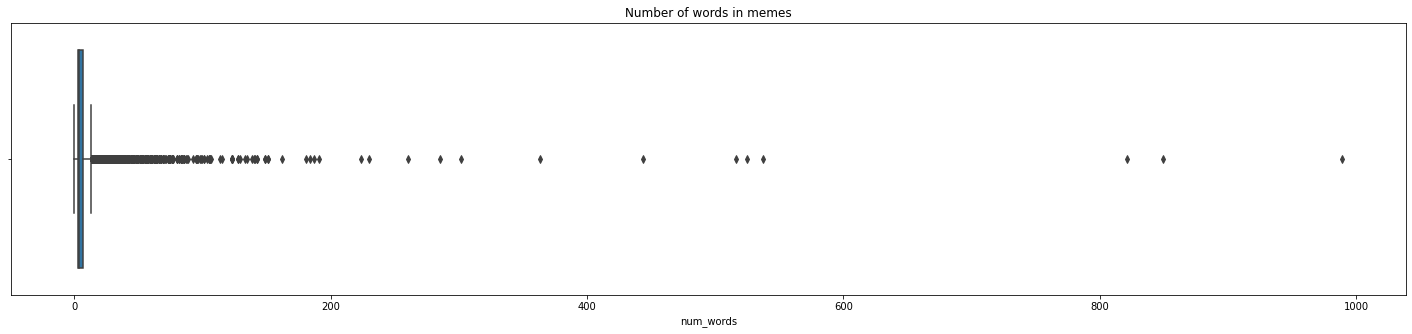

In [ ]:
plt.figure(figsize=(25,5))
sns.boxplot(df['num_words'])
plt.title('Number of words in memes')
plt.show()

Here we can see that most of the memes have words less than 100.<br>
Lets see with the help of percentiles.

In [ ]:
np.percentile(df['num_words'],99.9)

75.0

In [ ]:
for i in range(90,101):
  print(i,'percentile : ',np.percentile(df['num_words'],i))

90 percentile :  10.0
91 percentile :  11.0
92 percentile :  12.0
93 percentile :  12.0
94 percentile :  13.0
95 percentile :  14.0
96 percentile :  15.0
97 percentile :  17.0
98 percentile :  21.0
99 percentile :  28.0
100 percentile :  989.0


There is huge jump between 99th and 100th percentile. Lets visualize between them.

In [ ]:
for i in np.arange(99,100.1,0.1):
  print(i,'percentile : ',np.percentile(df['num_words'],i))

99.0 percentile :  28.0
99.1 percentile :  29.0
99.19999999999999 percentile :  31.0
99.29999999999998 percentile :  33.0
99.39999999999998 percentile :  35.0
99.49999999999997 percentile :  37.0
99.59999999999997 percentile :  41.0
99.69999999999996 percentile :  47.0
99.79999999999995 percentile :  56.0
99.89999999999995 percentile :  75.0
99.99999999999994 percentile :  988.9999999938882


There is huge jump between 99.9th and 100th percentile. So, we can remove the data points which have number of words greater than 75. 

In [ ]:
df = df[df['num_words']<=75]

In [ ]:
df.shape[0]

83826

Now we are left with **83826** data points.

### Dropping unimportant columns

In [ ]:
df.drop(['created_utc','subreddit','url'], axis=1, inplace=True)

### Encoding 'is_original_content' column

In [ ]:
df['is_original_content'] = df['is_original_content'].astype('int')

### Encoding 'over_18' column

In [ ]:
df['over_18'] = df['over_18'].astype('int')

### <br><br>Encoding image feature column<br>
Idea to encode this feature is that, I will take top 10 objects from top 5% (dank) data points, lower 5% from least popular memes and 10 features which are shared among most and least popular memes.

In [ ]:
top_5 = df[df['score']>np.percentile(df['score'],95)]['img_feature']
least_5 = df[df['score']<np.percentile(df['score'],5)]['img_feature']

In [ ]:
#list data are in form of string, converting them to list
from ast import literal_eval
top_5 = top_5.apply(literal_eval)
least_5 = least_5.apply(literal_eval)

In [ ]:
#storing all the words present im top 5% features
top_list=[]
for value in top_5:
    top_list.extend(value)

In [ ]:
#storing all the words present im bottom 5% features
least_list=[]
for value in least_5:
    least_list.extend(value)

Getting top 10 **shared** objects

In [ ]:
top_obj = pd.DataFrame(top_list).value_counts()[:11].index.to_frame(index=False)[0]

In [ ]:
least_obj = pd.DataFrame(least_list).value_counts()[:10].index.to_frame(index=False)[0]

In [ ]:
shared = set(top_obj).intersection(set(least_obj))

Getting top 10 **most popular** objects which are not shared

In [ ]:
top_obj = pd.DataFrame(top_list).value_counts()[:47].index.to_frame(index=False)[0]

In [ ]:
least_obj = pd.DataFrame(least_list).value_counts()[:47].index.to_frame(index=False)[0]

In [ ]:
most_pop = set(top_obj) - set(least_obj)

Getting top 10 **least popular** objects which are not shared

In [ ]:
least_obj = pd.DataFrame(least_list).value_counts()[-10:].index.to_frame(index=False)[0]

In [ ]:
top_obj = pd.DataFrame(top_list).value_counts()[:47].index.to_frame(index=False)[0]

In [ ]:
least_pop = set(least_obj) - set(top_obj)

In [ ]:
#showing top 10 words in top 5%, bottom 5% and shared data
from prettytable import PrettyTable
x = PrettyTable()

In [ ]:
x.add_column("Shared",list(shared))
x.add_column("Top 5%",list(most_pop))
x.add_column("Bottom 5%",list(least_pop))

In [ ]:
print(x)

+---------------+------------------+-------------+
|     Shared    |      Top 5%      |  Bottom 5%  |
+---------------+------------------+-------------+
|     screen    | bulletproof_vest |   milk_can  |
|   television  |   oxygen_mask    |  mud_turtle |
| jigsaw_puzzle |    Chihuahua     |  bee_eater  |
|    web_site   |    can_opener    | mixing_bowl |
|  book_jacket  |    ballplayer    |     mink    |
|     packet    |     marimba      |    otter    |
|    envelope   |       pick       |    beaver   |
|      menu     |     bookshop     |    organ    |
|    monitor    |   balance_beam   |   meerkat   |
|   comic_book  |  academic_gown   |   zucchini  |
+---------------+------------------+-------------+


In [ ]:
#list in img_feature column are in form of string, converting them to list
df['img_feature'] = df['img_feature'].apply(literal_eval)

In [ ]:
#now combining all elements of list as one string
df['img_feature'] = df['img_feature'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
#storing all the 30 words so that we can use them during bag of words creation
vocab = []
vocab.extend(list(most_pop))
vocab.extend(list(least_pop))
vocab.extend(list(shared))

In [ ]:
#using countvectorizer to create bag of words
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer(vocabulary=vocab)

In [ ]:
img_feature_vec = cv.fit_transform(df['img_feature'])

In [ ]:
img_feature_vec = pd.DataFrame(img_feature_vec.toarray(),columns=cv.get_feature_names())

In [ ]:
#joining all bag of word features to original dataset
df = df.reset_index().join(img_feature_vec)

In [ ]:
df.drop(['index','img_feature'], axis=1, inplace=True)

In [ ]:
#saving the dataset
df.to_csv('df_clean.csv', index=False)

# <br><br>Exploratory Data Analysis<br>

In [35]:
df = pd.read_csv("/content/drive/MyDrive/Applied_ai/df_clean.csv")

### Time vs normalized score
Here I am trying to visualize when in a day meme should be posted so that it's chance of becoming dank increases.<br>
To do that I will divide the time in different ranges and visualise each range.

In [ ]:
#Dividing hours in six groups, each group has four hour timeframe. 
hour_range = []
for i in df['hour']:
  if i>=0 and i<=4:
    hour_range.append('12am-4am')
  elif i>4 and i<=8:
    hour_range.append('4am-8am')
  elif i>8 and i<=12:
    hour_range.append('8am-12pm')
  elif i>12 and i<=16:
    hour_range.append('12pm-4pm')
  elif i>16 and i<=20:
    hour_range.append('4pm-8pm')
  elif i>20 and i<=23:
    hour_range.append('8pm-12am')

In [ ]:
df['hour_range'] = hour_range

In [ ]:
'''
groupby the dataset on hour_range column and getting mean of dank_or_not column in these timeframes
so that we can find relation between timeframe and dankness of the memes.
'''
grpby_hr_don = df.groupby('hour_range')['dank_or_not'].mean()

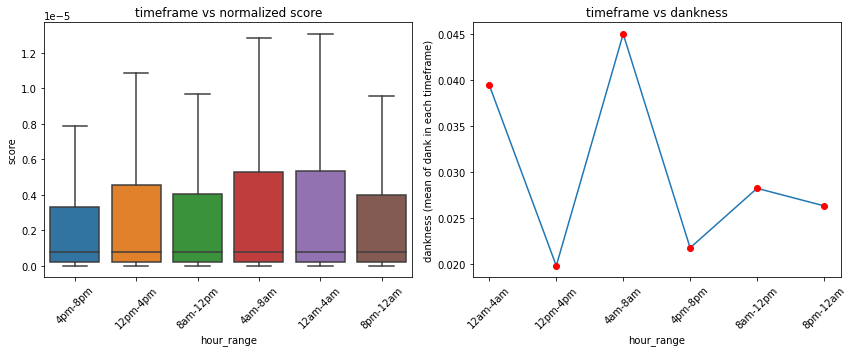

In [ ]:
#plotting graphs
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x='hour_range', y='score', data=df,showfliers=False)
plt.title('timeframe vs normalized score')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.plot(grpby_hr_don.index,grpby_hr_don.values)
plt.plot(grpby_hr_don.index,grpby_hr_don.values, 'ro')
plt.title('timeframe vs dankness')
plt.xlabel('hour_range')
plt.ylabel('dankness (mean of dank in each timeframe)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

From the plot above we can see that the memes which are posted between 12am to 4am have highest score values followed by 4am to 8am. Reason for this can be that most of the users scrolls social networking sites just before sleeping for the case of 12am to 4am and just after waking up for case of 4am to 8 am. One more reason can be, people need humor just before sleeping and just after waking up.<br>
Memes have least score when posted between 4pm to 8pm.  

### Sentiment score vs Normalized score
Here I am trying to find, what should be the sentiment of text in the meme to be dank.

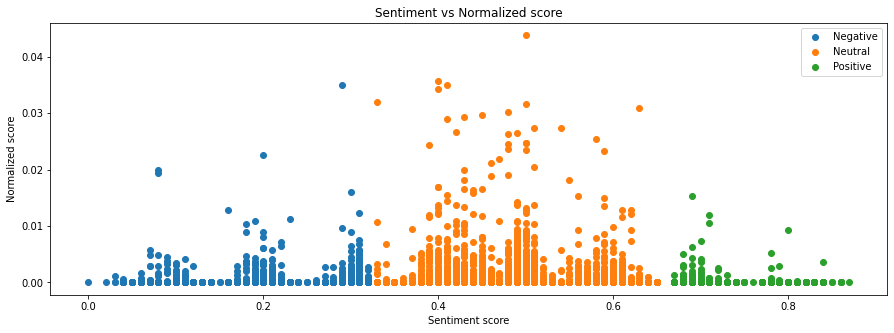

In [ ]:
#plotting negative, neutral and positive sentiments on same graph
plt.figure(figsize=(15,5))
#positive
plt.scatter(df[df['sentiment_score']<0.33]['sentiment_score'], df[df['sentiment_score']<0.33]['score'])
#neutral
plt.scatter(df[(df['sentiment_score']>=0.33) & (df['sentiment_score']<0.66)]['sentiment_score'], df[(df['sentiment_score']>=0.33) & (df['sentiment_score']<0.66)]['score'])
#negative
plt.scatter(df[df['sentiment_score']>0.66]['sentiment_score'], df[df['sentiment_score']>0.66]['score'])

plt.title('Sentiment vs Normalized score')
plt.xlabel('Sentiment score')
plt.ylabel('Normalized score')
plt.legend(['Negative','Neutral','Positive'])
plt.show()

Here we can see that, 
* neutral texts have highest chances of becoming dank.
* Between positive and negative sentiments, text with negative sentiment in the meme have higher chances of becoming dank.

### Text length vs Normalized score

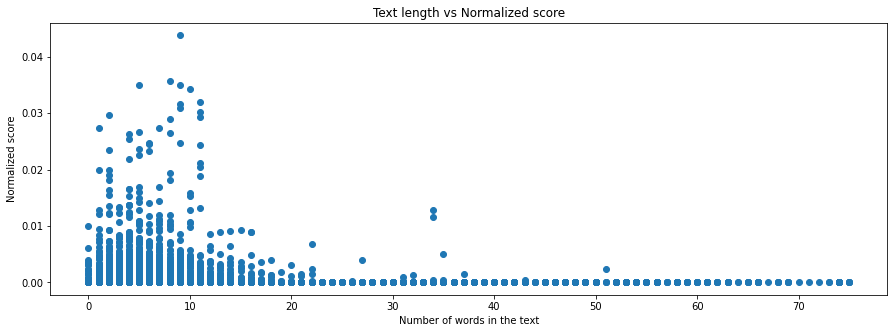

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(df['num_words'], df['score'])

plt.title('Text length vs Normalized score')
plt.xlabel('Number of words in the text')
plt.ylabel('Normalized score')
plt.show()

* Text with word length less than 12 is most preferable and have high chances of becoming dank and it's obvious, peoplr don't like to read long texts for a pinch of humor. 
* Texts with word length greater than 11 is least preferable.

### Word cloud for text column

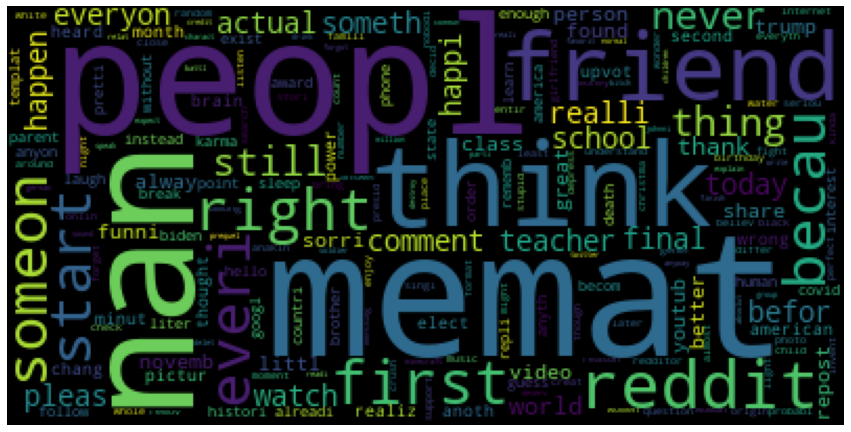

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(15,10))
text = " ".join(i for i in df['text'].astype(str))
wordcloud = WordCloud().generate(text)
# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Here we can see that some of the words are not so important for meme such as 'memat' which is mematic, a website where memers create memes and all the memes created from mematic have it's watermark and OCR reads those watermarks. 'reddit', from where we have extracted data. 'nan', rows where no words are present.<br>
So, let's remove these words and generate word cloud again.

In [ ]:
text = text.replace('memat','').replace('reddit','').replace('nan','')

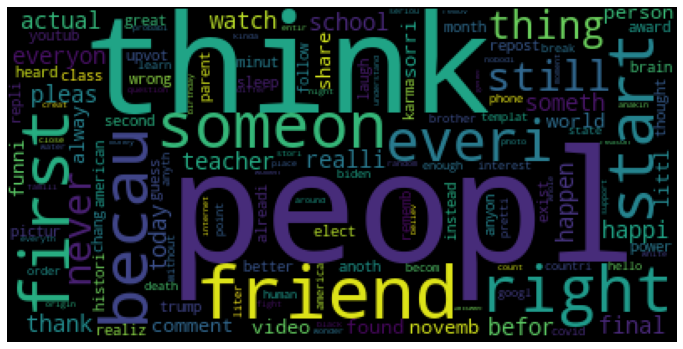

In [ ]:
plt.figure(figsize=(12,10))
wordcloud = WordCloud().generate(text)
# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Some of the most frequent words in the memes are 'people','think','because','someone','something','still','really','friend','teacher' etc.

### Color vs Normalized pixels
We have extracted normalized pixel (numper of pixel of a color divider by total umber of pixels of the image) for colors in the images. <br>
We will sum all the normalized pixels of a color and those color which have maximum value are most frequent color in the meme.

In [ ]:
#adding all the normalized pixels of a color and dividing it by number of data available
white     = df['white'].sum()/df.shape[0]
black     = df['black'].sum()/df.shape[0]
gray      = df['gray'].sum()/df.shape[0]
brown     = df['brown'].sum()/df.shape[0]
off_white = df['off-white'].sum()/df.shape[0]
dark_red  = df['dark red'].sum()/df.shape[0]
light_red = df['light red'].sum()/df.shape[0]
dark_orange   = df['dark orange'].sum()/df.shape[0]
light_orange  = df['light orange'].sum()/df.shape[0]
goldish       = df['goldish'].sum()/df.shape[0]
yellow        = df['yellow'].sum()/df.shape[0]
dark_green    = df['dark green'].sum()/df.shape[0]
light_green   = df['light green'].sum()/df.shape[0]
dark_cyan     = df['dark cyan'].sum()/df.shape[0]
cyan          = df['cyan'].sum()/df.shape[0]
dark_blue     = df['dark blue'].sum()/df.shape[0]
light_blue    = df['light blue'].sum()/df.shape[0]
purple        = df['purple'].sum()/df.shape[0]
pink          = df['pink'].sum()/df.shape[0]
faded_colors  = df['faded colors'].sum()/df.shape[0]

In [ ]:
#creating a dictionary to store colors and their corresponding pixel value
x = {'white':white,'black':black,'gray':gray,'brown':brown,'off white':off_white,
     'dark red':dark_red,'light red':light_red,'dark orange':dark_orange,'light orange':light_orange,
     'goldish':goldish,'yellow':yellow,'dark_green':dark_green,'light green':light_green,
     'dark cyan':dark_cyan,'cyan':cyan,'dark blue':dark_blue,'light blue':light_blue,'purple':purple,
     'pink':pink,'faded colors':faded_colors}

In [ ]:
#sorting the dictionary
x = dict(sorted(x.items(), key=lambda item: item[1]))

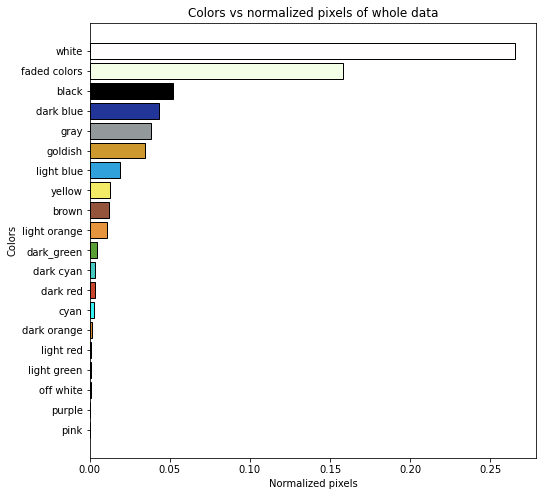

In [ ]:
#plotting Color vs Normalized pixels
plt.figure(figsize=(8,8))
color = plt.barh(list(x.keys()),list(x.values()), height=0.8)

#setting different colors for different bars
color[-1].set_color('#FFFDFD')
color[-1].set_edgecolor('black')
color[-2].set_color('#F3FFE6')
color[-2].set_edgecolor('black')
color[-3].set_color('#000000')
color[-3].set_edgecolor('black')
color[-4].set_color('#22369A')
color[-4].set_edgecolor('black')
color[-5].set_color('#93989A')
color[-5].set_edgecolor('black')
color[-6].set_color('#CD982D')
color[-6].set_edgecolor('black')
color[-7].set_color('#30A1DA')
color[-7].set_edgecolor('black')
color[-8].set_color('#F3EA66')
color[-8].set_edgecolor('black')
color[-9].set_color('#94533B')
color[-9].set_edgecolor('black')
color[-10].set_color('#E6953E')
color[-10].set_edgecolor('black')
color[-11].set_color('#599F36')
color[-11].set_edgecolor('black')
color[-12].set_color('#44C8BF')
color[-12].set_edgecolor('black')
color[-13].set_color('#C8462C')
color[-13].set_edgecolor('black')
color[-14].set_color('#35F1F1')
color[-14].set_edgecolor('black')
color[-15].set_color('#D7832F')
color[-15].set_edgecolor('black')
color[-16].set_color('#EC5234')
color[-16].set_edgecolor('black')
color[-17].set_color('#71EC34')
color[-17].set_edgecolor('black')
color[-18].set_color('#C8C098')
color[-18].set_edgecolor('black')
color[-19].set_color('#AE2CC8')
color[-19].set_edgecolor('black')
color[-20].set_color('#E633AA')
color[-20].set_edgecolor('black')

plt.title('Colors vs normalized pixels of whole data')
plt.xlabel('Normalized pixels')
plt.ylabel('Colors')
plt.show()

In most of the memes white, faded and dark colors are used. Light and bright colors are rarely used in the memes.In general, muted colors are more abundant than bright colors in memes. Perhaps because memes tend to be mundane photos, often blurry in self-made way, unlike professional photography.<br>
#### Let's visualize this for only dank memes

In [ ]:
#Getting on dank meme data
dank = df[df['dank_or_not']==1]

In [ ]:
#adding all the normalized pixels of a color and dividing it by number of data available
white     = dank['white'].sum()/dank.shape[0]
black     = dank['black'].sum()/dank.shape[0]
gray      = dank['gray'].sum()/dank.shape[0]
brown     = dank['brown'].sum()/dank.shape[0]
off_white = dank['off-white'].sum()/dank.shape[0]
dark_red  = dank['dark red'].sum()/dank.shape[0]
light_red = dank['light red'].sum()/dank.shape[0]
dark_orange   = dank['dark orange'].sum()/dank.shape[0]
light_orange  = dank['light orange'].sum()/dank.shape[0]
goldish       = dank['goldish'].sum()/dank.shape[0]
yellow        = dank['yellow'].sum()/dank.shape[0]
dark_green    = dank['dark green'].sum()/dank.shape[0]
light_green   = dank['light green'].sum()/dank.shape[0]
dark_cyan     = dank['dark cyan'].sum()/dank.shape[0]
cyan          = dank['cyan'].sum()/dank.shape[0]
dark_blue     = dank['dark blue'].sum()/dank.shape[0]
light_blue    = dank['light blue'].sum()/dank.shape[0]
purple        = dank['purple'].sum()/dank.shape[0]
pink          = dank['pink'].sum()/dank.shape[0]
faded_colors  = dank['faded colors'].sum()/dank.shape[0]

In [ ]:
#creating a dictionary to store colors and their corresponding pixel value
x = {'white':white,'black':black,'gray':gray,'brown':brown,'off white':off_white,
     'dark red':dark_red,'light red':light_red,'dark orange':dark_orange,'light orange':light_orange,
     'goldish':goldish,'yellow':yellow,'dark_green':dark_green,'light green':light_green,
     'dark cyan':dark_cyan,'cyan':cyan,'dark blue':dark_blue,'light blue':light_blue,'purple':purple,
     'pink':pink,'faded colors':faded_colors}

In [ ]:
#sorting the dictionary
x = dict(sorted(x.items(), key=lambda item: item[1]))

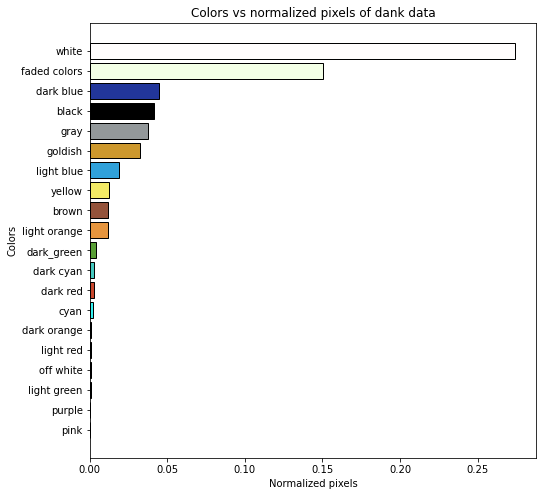

In [ ]:
#plotting Color vs Normalized pixels
plt.figure(figsize=(8,8))
color = plt.barh(list(x.keys()),list(x.values()), height=0.8)

#setting different colors for different bars
color[-1].set_color('#FFFDFD')
color[-1].set_edgecolor('black')
color[-2].set_color('#F3FFE6')
color[-2].set_edgecolor('black')
color[-3].set_color('#22369A')
color[-3].set_edgecolor('black')
color[-4].set_color('#000000')
color[-4].set_edgecolor('black')
color[-5].set_color('#93989A')
color[-5].set_edgecolor('black')
color[-6].set_color('#CD982D')
color[-6].set_edgecolor('black')
color[-7].set_color('#30A1DA')
color[-7].set_edgecolor('black')
color[-8].set_color('#F3EA66')
color[-8].set_edgecolor('black')
color[-9].set_color('#94533B')
color[-9].set_edgecolor('black')
color[-10].set_color('#E6953E')
color[-10].set_edgecolor('black')
color[-11].set_color('#599F36')
color[-11].set_edgecolor('black')
color[-12].set_color('#44C8BF')
color[-12].set_edgecolor('black')
color[-13].set_color('#C8462C')
color[-13].set_edgecolor('black')
color[-14].set_color('#35F1F1')
color[-14].set_edgecolor('black')
color[-15].set_color('#D7832F')
color[-15].set_edgecolor('black')
color[-16].set_color('#EC5234')
color[-16].set_edgecolor('black')
color[-17].set_color('#71EC34')
color[-17].set_edgecolor('black')
color[-18].set_color('#C8C098')
color[-18].set_edgecolor('black')
color[-19].set_color('#AE2CC8')
color[-19].set_edgecolor('black')
color[-20].set_color('#E633AA')
color[-20].set_edgecolor('black')

plt.title('Colors vs normalized pixels of dank data')
plt.xlabel('Normalized pixels')
plt.ylabel('Colors')
plt.show()

Dank memes colors are approximately same as the whole data. Means memers should not bother about the picture quality or putting bright tangy colors on the memes, the content of the meme should be good and people love them.

### HSV vs Normalized score
Visualizing average Hue, Saturation and Value vs Normalized score.

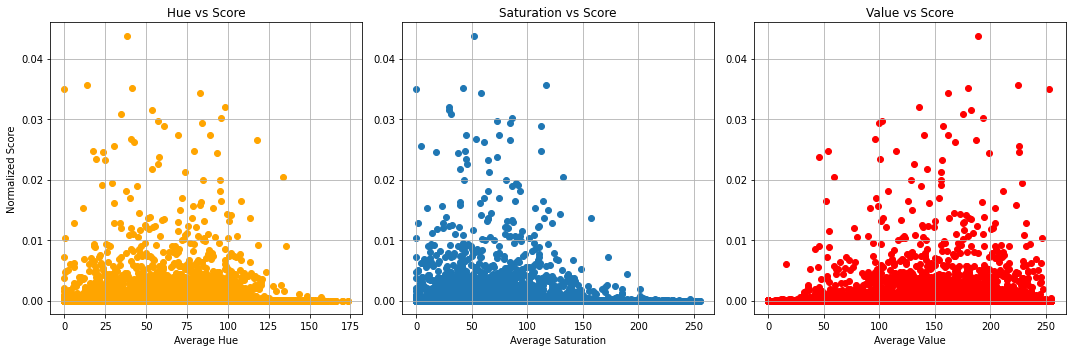

In [ ]:
plt.figure(figsize=(15,5))

#plotting average hue vs normalized score
plt.subplot(1,3,1)
plt.scatter(df['avg_h'],df['score'], color='orange')
plt.title('Hue vs Score')
plt.xlabel('Average Hue')
plt.ylabel('Normalized Score')
plt.grid()

#plotting average saturation vs normalized score
plt.subplot(1,3,2)
plt.scatter(df['avg_s'],df['score'])
plt.title('Saturation vs Score')
plt.xlabel('Average Saturation')
plt.grid()

#plotting average value vs normalized score
plt.subplot(1,3,3)
plt.scatter(df['avg_v'],df['score'], color='red')
plt.title('Value vs Score')
plt.xlabel('Average Value')
plt.grid()

plt.tight_layout()
plt.show()

From above plots we can see that:

* For a meme to get high score (upvotes minus downvotes) hue should be low (approximately between 10 to 125 in opencv).
* For a meme to get high score the saturation value should also be low (approximately between 0 to 140 in opencv).
* For a meme to get high score the value should be higher (approximately between 100 to 200 in opencv).
<br>
Figure below will provide a rough idea:<br>

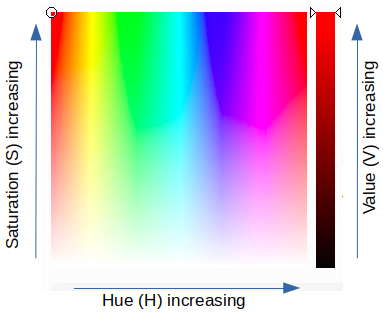

In [ ]:
df['is_original_content'].value_counts()

0    83154
1      672
Name: is_original_content, dtype: int64

### Number of comments vs Normalized score

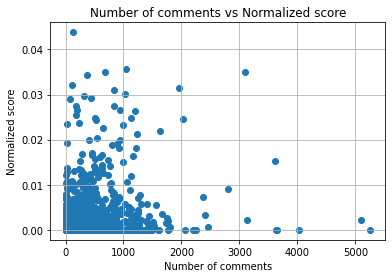

In [ ]:
plt.scatter(df['num_comments'], df['score'])
plt.title('Number of comments vs Normalized score')
plt.xlabel('Number of comments')
plt.ylabel('Normalized score')
plt.grid()
plt.show()

Here we can see that there is no clear relation between number of comments and Normalized score, because even memes with zero number of comments have high scores and memes with large number of comments have low scores.

### Thumbnail height and width vs normalized score

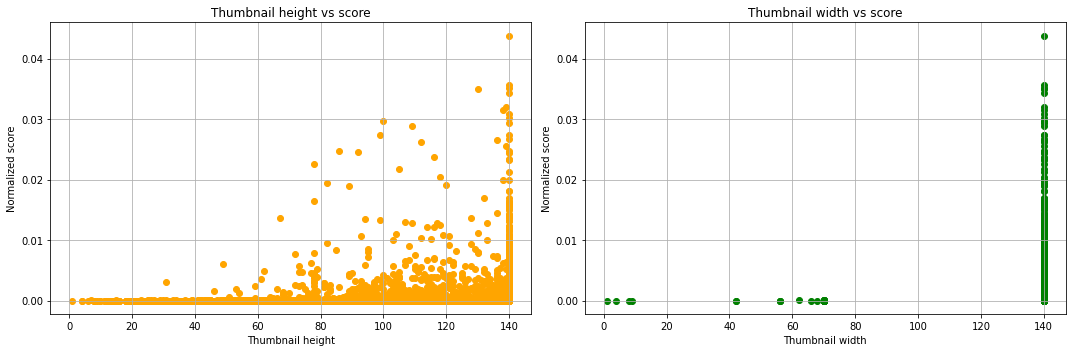

In [ ]:
#thumbnail height
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(df['thumbnail_height'], df['score'], color='orange')
plt.title('Thumbnail height vs score')
plt.xlabel('Thumbnail height')
plt.ylabel('Normalized score')
plt.grid()

#thumbnail width
plt.subplot(1,2,2)
plt.scatter(df['thumbnail_width'], df['score'],color='green')
plt.title('Thumbnail width vs score')
plt.xlabel('Thumbnail width')
plt.ylabel('Normalized score')
plt.grid()

plt.tight_layout()
plt.show()

Mostly thumbnail with height greater than 80 have high scores and almost all of the thumbnails have 140 width means there is no correlation between score and thumbnail width. 